## 1) Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
import keras

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data.csv')
del data['Unnamed: 0']

labels = np.load('labels.npy')

## 2) Preprocessing steps with data & features

In [3]:
# features which we want to delete
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

# columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
# features normalization
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = np.abs((xs - np.mean(xs)) / np.std(xs))

In [5]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), 
               data['_instantLumi_muons'].get_values()),
               data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [6]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

In [7]:
del data['_luminosityBlock']
del data['_run']
del data['_instantLumi_minibias']
del data['_instantLumi_muons']
del data['_instantLumi_photons']

In [8]:
data['labels'] = pd.Series(labels, index=data.index)

In [9]:
data.head()

,minibias_PF_Px_mean,minibias_PF_Px_p1,minibias_PF_Px_p25,minibias_PF_Px_p50,minibias_PF_Px_p75,minibias_PF_Px_p99,minibias_PF_Px_std,minibias_PF_Py_mean,minibias_PF_Py_p1,minibias_PF_Py_p25,...,photons_photons_pt__q4_p99,photons_photons_pt__q4_std,photons_photons_pt__q5_mean,photons_photons_pt__q5_p1,photons_photons_pt__q5_p25,photons_photons_pt__q5_p50,photons_photons_pt__q5_p75,photons_photons_pt__q5_p99,photons_photons_pt__q5_std,labels
0,0.553982,0.121924,2.377744,2.979489,3.999278,0.334869,0.185235,0.141756,0.041391,3.517199,...,0.771053,0.613178,0.671934,0.115348,0.529921,0.626325,0.669504,0.781640,0.624168,0.0
1,0.618719,0.140093,2.245878,3.164899,4.423358,0.350631,0.162238,0.141120,0.119621,3.520591,...,1.448301,0.720708,0.596897,0.115348,0.500126,0.613411,0.762044,0.373972,0.564393,0.0
2,0.590468,0.089144,2.267943,3.180846,4.379818,0.322018,0.174552,0.094414,0.091330,3.533495,...,0.315584,0.565043,0.521407,0.115348,0.398654,0.593673,0.525674,1.095464,0.607292,0.0
3,0.563941,0.119073,2.135948,3.271239,4.200118,0.282537,0.179577,0.155060,0.146141,3.579560,...,1.116072,0.778321,0.669518,0.115348,0.659620,0.662089,0.603566,0.905891,0.494840,0.0
4,0.512639,0.077763,2.699199,2.974805,4.191212,0.289252,0.170892,0.122369,0.076968,3.478975,...,0.397704,0.620604,0.533768,0.115348,0.444284,0.585253,0.609742,1.004260,0.574727,0.0


In [10]:
from sklearn.model_selection import train_test_split

data_shuffle = data.sample(frac=1)

df = np.array(data_shuffle)

X_train, X_test = train_test_split(df, test_size=0.15)

In [11]:
print(X_train.shape,
X_test.shape)

(22139, 2695) (3907, 2695)


## 3) Build the network/autoencoder


## I. 1 hidden layer

### 1) input 2695 - 2695 - output 2695

In [12]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.activations import relu
from keras.regularizers import l2
from keras.initializers import Orthogonal

In [13]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2695, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [14]:
ae, ae_encoder = make_autoencoder()

In [15]:
from keras.optimizers import Adamax
from keras.objectives import MSE

In [16]:
ae.compile(optimizer=Adamax(), loss=MSE)

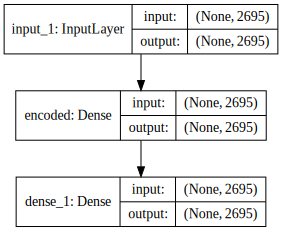

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
history = ae.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 3s - loss: 0.2593 - val_loss: 0.1645
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1483 - val_loss: 0.1521
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1437 - val_loss: 0.1388
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1026 - val_loss: 0.1303
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0790 - val_loss: 0.1257
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0666 - val_loss: 0.1203
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0580 - val_loss: 0.1164
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0532 - val_loss: 0.1129
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0511 - val_loss: 0.1101
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0517 - val_los

In [18]:
X_pred = ae.predict(X_test)
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

Test MSE: 0.0625033148153


In [19]:
dim_loss = []
dim_loss.append([2695, np.mean((X_pred - X_test) ** 2)])

In [20]:
dim_loss

[[2695, 0.062503314815317651]]

### 2) input 2695 - 2600 - output 2695

In [18]:
def make_autoencoder2():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2600, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [19]:
ae2, ae_encoder2 = make_autoencoder2()

ae2.compile(optimizer=Adamax(), loss=MSE)

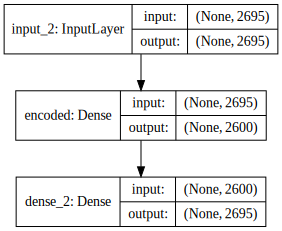

In [20]:
SVG(model_to_dot(ae2, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
history2 = ae2.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 3s - loss: 0.2716 - val_loss: 0.1682
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1779 - val_loss: 0.1539
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1397 - val_loss: 0.1424
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1366ss: 0.0
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0828 - val_loss: 0.1305
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0721 - val_loss: 0.1263
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0655 - val_loss: 0.1226
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0597 - val_loss: 0.1188
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0560 - val_loss: 0.1156
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0515 - 

In [24]:
X_pred2 = ae2.predict(X_test)
print('Test MSE:', np.mean((X_pred2 - X_test) ** 2))

Test MSE: 0.0603632360052


In [25]:
dim_loss.append([2600, np.mean((X_pred2 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651], [2600, 0.060363236005186172]]

### 3) input 2695 - 2500 - output 2695

In [26]:
def make_autoencoder3():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [27]:
ae3, ae_encoder3 = make_autoencoder3()

ae3.compile(optimizer=Adamax(), loss=MSE)

history3 = ae3.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2529 - val_loss: 0.1643
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1551 - val_loss: 0.1484
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1426 - val_loss: 0.1399
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1046 - val_loss: 0.1306
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0793 - val_loss: 0.1260
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0668 - val_loss: 0.1217
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0602 - val_loss: 0.1180
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0568 - val_loss: 0.1147
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0533 - val_loss: 0.1110
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0502 - val_los

In [28]:
X_pred3 = ae3.predict(X_test)
print('Test MSE:', np.mean((X_pred3 - X_test) ** 2))

Test MSE: 0.0572131000268


In [29]:
dim_loss.append([2500, np.mean((X_pred3 - X_test) ** 2)])
dim_loss 

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709]]

In [85]:
ae3.save('/home/mkarpov/CMS_Project/ae3_2500.h5')

### 4) input 2695 - 2400 - output 2695

In [30]:
def make_autoencoder4():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2400, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae4, ae_encoder4 = make_autoencoder4()

ae4.compile(optimizer=Adamax(), loss=MSE)

history4 = ae4.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2577 - val_loss: 0.1685
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1562 - val_loss: 0.1512
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1357 - val_loss: 0.1398
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1061 - val_loss: 0.1340
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0840 - val_loss: 0.1280
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0694 - val_loss: 0.1233
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0606 - val_loss: 0.1196
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0546 - val_loss: 0.1159
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0513 - val_loss: 0.1130
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0504 - val_los

In [31]:
X_pred4 = ae4.predict(X_test)
print('Test MSE:', np.mean((X_pred4 - X_test) ** 2))

Test MSE: 0.0597237198795


In [32]:
dim_loss.append([2400, np.mean((X_pred4 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186]]

### 5) input 2695 - 2300 - output 2695

In [33]:
def make_autoencoder5():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2400, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae5, ae_encoder5 = make_autoencoder5()

ae5.compile(optimizer=Adamax(), loss=MSE)

history5 = ae5.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2508 - val_loss: 0.1682
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1747 - val_loss: 0.1466
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1139 - val_loss: 0.1347
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.0898 - val_loss: 0.1282
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0775 - val_loss: 0.1234
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0806 - val_loss: 0.1199
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0630 - val_loss: 0.1146
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0569 - val_loss: 0.1117
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0552 - val_loss: 0.1082
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0553 - val_los

In [34]:
X_pred5 = ae5.predict(X_test)
print('Test MSE:', np.mean((X_pred5 - X_test) ** 2))

Test MSE: 0.0589702553883


In [35]:
dim_loss.append([2300, np.mean((X_pred5 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346]]

### 6) input 2695 - 2200 - output 2695

In [36]:
def make_autoencoder6():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2300, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae6, ae_encoder6 = make_autoencoder6()

ae6.compile(optimizer=Adamax(), loss=MSE)

history6 = ae6.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2571 - val_loss: 0.1656
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1639 - val_loss: 0.1490
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1327 - val_loss: 0.1409
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.0987 - val_loss: 0.1324
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0800 - val_loss: 0.1265
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0689 - val_loss: 0.1226
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0649 - val_loss: 0.1179
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0611 - val_loss: 0.1155
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0582 - val_loss: 0.1121
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0545 - val_los

In [37]:
X_pred6 = ae6.predict(X_test)
print('Test MSE:', np.mean((X_pred6 - X_test) ** 2))

Test MSE: 0.0591931043107


In [38]:
dim_loss.append([2200, np.mean((X_pred6 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346],
 [2200, 0.0591931043106897]]

### 7) input 2695 - 2100 - output 2695

In [39]:
def make_autoencoder7():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2100, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae7, ae_encoder7 = make_autoencoder7()

ae7.compile(optimizer=Adamax(), loss=MSE)

history7 = ae7.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2462 - val_loss: 0.1641
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1830 - val_loss: 0.1550
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1297 - val_loss: 0.1406
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.0986 - val_loss: 0.1343
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0811 - val_loss: 0.1295
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0708 - val_loss: 0.1250
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0631 - val_loss: 0.1213
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0582 - val_loss: 0.1175
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0556 - val_loss: 0.1142
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0556 - val_los

In [40]:
X_pred7 = ae7.predict(X_test)
print('Test MSE:', np.mean((X_pred7 - X_test) ** 2))

Test MSE: 0.0598141035604


In [41]:
dim_loss.append([2100, np.mean((X_pred7 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346],
 [2200, 0.0591931043106897],
 [2100, 0.059814103560408269]]

### 8) input 2695 - 2000 - output 2695

In [43]:
def make_autoencoder8():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        2000, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae8, ae_encoder8 = make_autoencoder8()

ae8.compile(optimizer=Adamax(), loss=MSE)

history8 = ae8.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2458 - val_loss: 0.1668
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1563 - val_loss: 0.1498
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1385 - val_loss: 0.1388
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1051 - val_loss: 0.1318
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0840 - val_loss: 0.1271
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0718 - val_loss: 0.1226
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0650 - val_loss: 0.1191
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0612 - val_loss: 0.1155
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0582 - val_loss: 0.1137
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0528 - val_los

In [44]:
X_pred8 = ae8.predict(X_test)
print('Test MSE:', np.mean((X_pred8 - X_test) ** 2))

Test MSE: 0.0620895969642


In [45]:
dim_loss.append([2000, np.mean((X_pred8 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346],
 [2200, 0.0591931043106897],
 [2100, 0.059814103560408269],
 [2000, 0.062089596964235869]]

### 9) input 2695 - 1900 - output 2695

In [47]:
def make_autoencoder9():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        1900, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae9, ae_encoder9 = make_autoencoder9()

ae9.compile(optimizer=Adamax(), loss=MSE)

history9 = ae9.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2523 - val_loss: 0.1671
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1695 - val_loss: 0.1532
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1331 - val_loss: 0.1426
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1108 - val_loss: 0.1355
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0872 - val_loss: 0.1293
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0745 - val_loss: 0.1252
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0661 - val_loss: 0.1214
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0606 - val_loss: 0.1181
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0575 - val_loss: 0.1155
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0556 - val_los

In [48]:
X_pred9 = ae9.predict(X_test)
print('Test MSE:', np.mean((X_pred9 - X_test) ** 2))

Test MSE: 0.0608439078385


In [49]:
dim_loss.append([1900, np.mean((X_pred9 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346],
 [2200, 0.0591931043106897],
 [2100, 0.059814103560408269],
 [2000, 0.062089596964235869],
 [1900, 0.060843907838547588]]

### 10) input 2695 - 1800 - output 2695

In [51]:
def make_autoencoder10():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
      
    #Central layer
    encoded = Dense(
        1800, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(inputs)
    
    
    outputs = Dense(2695)(encoded)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

ae10, ae_encoder10 = make_autoencoder10()

ae10.compile(optimizer=Adamax(), loss=MSE)

history10 = ae10.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2465 - val_loss: 0.1727
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1570 - val_loss: 0.1529
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1268 - val_loss: 0.1440
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1087 - val_loss: 0.1377
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.0917 - val_loss: 0.1318
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.0768 - val_loss: 0.1278
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.0675 - val_loss: 0.1237
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.0618 - val_loss: 0.1202
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.0591 - val_loss: 0.1173
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.0565 - val_los

In [52]:
X_pred10 = ae10.predict(X_test)
print('Test MSE:', np.mean((X_pred10 - X_test) ** 2))

Test MSE: 0.0615843608185


In [53]:
dim_loss.append([1800, np.mean((X_pred10 - X_test) ** 2)])
dim_loss

[[2695, 0.062503314815317651],
 [2600, 0.060363236005186172],
 [2500, 0.057213100026750709],
 [2400, 0.059723719879496186],
 [2300, 0.058970255388278346],
 [2200, 0.0591931043106897],
 [2100, 0.059814103560408269],
 [2000, 0.062089596964235869],
 [1900, 0.060843907838547588],
 [1800, 0.06158436081853743]]

In [69]:
dim = [2695, 2600, 2500, 2400, 2300, 2200, 2100, 2000, 1900, 1800]
loss = [0.0625, 0.06036, 0.05721, 0.05972, 0.05897, 0.05919, 0.05981, 0.06209, 0.06084, 0.06158]

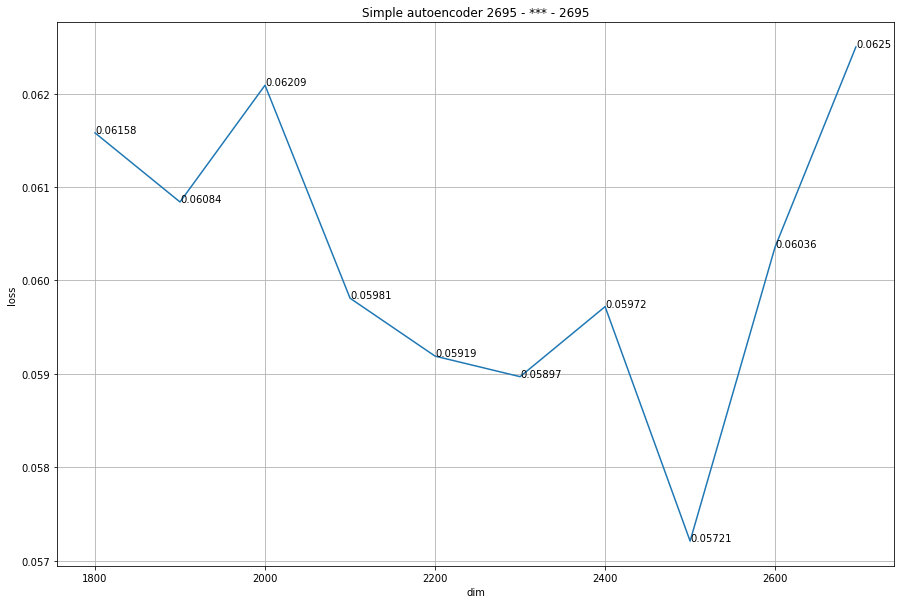

In [78]:
plt.figure(figsize=(15,10))
plt.plot(dim, loss)

for a,b in zip(dim, loss): 
    plt.text(a, b, str(b))

plt.xlabel('dim')
plt.ylabel('loss')
plt.title('Simple autoencoder 2695 - *** - 2695')
plt.grid(True)
plt.savefig("graph-1.png")
plt.show()

# To be continued...

## II. 3 hidden layers

Let's take 'top-3' dimensions and use them in encoder/decoder parts.

### 1) input 2695 - 2500 - 2400 - 2500 - output 2695

In [82]:
def make_autoencoder2_1():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
      
        
    #Central layer
    encoded = Dense(
        2400, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    #Decoder
    dedense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)

    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)


ae2_1, ae_encoder2_1 = make_autoencoder2_1()

ae2_1.compile(optimizer=Adamax(), loss=MSE)

history2_1 = ae2_1.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 5s - loss: 0.2771 - val_loss: 0.1658
Epoch 2/200
22139/22139 [==============================] - 4s - loss: 0.1742 - val_loss: 0.1500
Epoch 3/200
22139/22139 [==============================] - 4s - loss: 0.1534 - val_loss: 0.1408
Epoch 4/200
22139/22139 [==============================] - 4s - loss: 0.1335 - val_loss: 0.1348
Epoch 5/200
22139/22139 [==============================] - 4s - loss: 0.1439 - val_loss: 0.1325
Epoch 6/200
22139/22139 [==============================] - 4s - loss: 0.1207 - val_loss: 0.1264
Epoch 7/200
22139/22139 [==============================] - 4s - loss: 0.1113 - val_loss: 0.1248
Epoch 8/200
22139/22139 [==============================] - 4s - loss: 0.0958 - val_loss: 0.1200
Epoch 9/200
22139/22139 [==============================] - 4s - loss: 0.0889 - val_loss: 0.1167
Epoch 10/200
22139/22139 [==============================] - 4s - loss: 0.0962 - val_los

In [83]:
X_pred2_1 = ae2_1.predict(X_test)
print('Test MSE:', np.mean((X_pred2_1 - X_test) ** 2))

Test MSE: 0.0666325201886


In [84]:
dim2 = []
loss2 = []

dim2.append(2400)
loss2.append(np.mean((X_pred2_1 - X_test) ** 2))

print(dim2, loss2)

[2400] [0.066632520188610572]


### 2) input 2695 - 2500 - 2300 - 2500 - output 2695

In [14]:
def make_autoencoder2_2():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
      
        
    #Central layer
    encoded = Dense(
        2300, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    #Decoder
    dedense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)

    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)


ae2_2, ae_encoder2_2 = make_autoencoder2_2()

ae2_2.compile(optimizer=Adamax(), loss=MSE)

history2_2 = ae2_2.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 5s - loss: 0.2616 - val_loss: 0.1619
Epoch 2/200
22139/22139 [==============================] - 4s - loss: 0.1903 - val_loss: 0.1554
Epoch 3/200
22139/22139 [==============================] - 3s - loss: 0.1982 - val_loss: 0.1674
Epoch 4/200
22139/22139 [==============================] - 4s - loss: 0.1514 - val_loss: 0.1402
Epoch 5/200
22139/22139 [==============================] - 4s - loss: 0.1334 - val_loss: 0.1356
Epoch 6/200
22139/22139 [==============================] - 4s - loss: 0.1160 - val_loss: 0.1292
Epoch 7/200
22139/22139 [==============================] - 4s - loss: 0.1034 - val_loss: 0.1262
Epoch 8/200
22139/22139 [==============================] - 4s - loss: 0.0927 - val_loss: 0.1232
Epoch 9/200
22139/22139 [==============================] - 4s - loss: 0.0956 - val_loss: 0.1199
Epoch 10/200
22139/22139 [==============================] - 4s - loss: 0.0832 - val_los

In [21]:
X_pred2_2 = ae2_2.predict(X_test)
print('Test MSE:', np.mean((X_pred2_2 - X_test) ** 2))

dim_2 = []
loss_2 = []
      
dim_2.append(2400), dim_2.append(2300)
loss_2.append(0.066632520188610572), loss_2.append(np.mean((X_pred2_2 - X_test) ** 2))

print(dim_2, loss_2)

Test MSE: 0.0634755143738
[2400, 2300] [0.06663252018861057, 0.063475514373832309]


### 3) input 2695 - 2500 - 2200 - 2500 - output 2695

In [22]:
def make_autoencoder2_3():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
      
        
    #Central layer
    encoded = Dense(
        2200, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    #Decoder
    dedense1 = Dense(
        2500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)

    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)


ae2_3, ae_encoder2_3 = make_autoencoder2_3()

ae2_3.compile(optimizer=Adamax(), loss=MSE)

history2_3 = ae2_3.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

X_pred2_3 = ae2_3.predict(X_test)
print('Test MSE:', np.mean((X_pred2_3 - X_test) ** 2))
      
dim_2.append(2200)
loss_2.append(np.mean((X_pred2_3 - X_test) ** 2))

print(dim_2, loss_2)

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 4s - loss: 0.2896 - val_loss: 0.1656
Epoch 2/200
22139/22139 [==============================] - 4s - loss: 0.1708 - val_loss: 0.1539
Epoch 3/200
22139/22139 [==============================] - 4s - loss: 0.1665 - val_loss: 0.1434
Epoch 4/200
22139/22139 [==============================] - 4s - loss: 0.1316 - val_loss: 0.1385
Epoch 5/200
22139/22139 [==============================] - 4s - loss: 0.1203 - val_loss: 0.1322
Epoch 6/200
22139/22139 [==============================] - 4s - loss: 0.1248 - val_loss: 0.1277
Epoch 7/200
22139/22139 [==============================] - 4s - loss: 0.1150 - val_loss: 0.1285
Epoch 8/200
22139/22139 [==============================] - 4s - loss: 0.0969 - val_loss: 0.1221
Epoch 9/200
22139/22139 [==============================] - 4s - loss: 0.0939 - val_loss: 0.1184
Epoch 10/200
22139/22139 [==============================] - 4s - loss: 0.0871 - val_los

In [23]:
def make_autoencoder3_1():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2300, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
      
        
    #Central layer
    encoded = Dense(
        2000, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    #Decoder
    dedense1 = Dense(
        2300, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)

    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)


ae3_1, ae_encoder3_1 = make_autoencoder3_1()

ae3_1.compile(optimizer=Adamax(), loss=MSE)

history3_1 = ae3_1.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

X_pred3_1 = ae3_1.predict(X_test)
print('Test MSE:', np.mean((X_pred3_1 - X_test) ** 2))

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 4s - loss: 0.2640 - val_loss: 0.1691
Epoch 2/200
22139/22139 [==============================] - 3s - loss: 0.1839 - val_loss: 0.1494
Epoch 3/200
22139/22139 [==============================] - 4s - loss: 0.1538 - val_loss: 0.1419
Epoch 4/200
22139/22139 [==============================] - 3s - loss: 0.1375 - val_loss: 0.1366
Epoch 5/200
22139/22139 [==============================] - 3s - loss: 0.1343 - val_loss: 0.1311
Epoch 6/200
22139/22139 [==============================] - 3s - loss: 0.1220 - val_loss: 0.1271
Epoch 7/200
22139/22139 [==============================] - 3s - loss: 0.1063 - val_loss: 0.1233
Epoch 8/200
22139/22139 [==============================] - 4s - loss: 0.0959 - val_loss: 0.1206
Epoch 9/200
22139/22139 [==============================] - 4s - loss: 0.0815 - val_loss: 0.1171
Epoch 10/200
22139/22139 [==============================] - 3s - loss: 0.0831 - val_los

### 2) 5 hidden layers, input 2695 - 1347 - 673 - 336 - 673 - 1347 - output 2695

In [66]:
def make_autoencoder2():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
    
    dense2 = Dense(
        673, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dense1)
      
        
    #Central layer
    encoded = Dense(
        336, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense2)
    
    
    #Decoder
    dedense1 = Dense(
        673, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)
    
    dedense2 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dedense1)
    
    
    outputs = Dense(2695)(dedense2)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [67]:
ae2, ae_encoder2 = make_autoencoder2()

ae2.compile(optimizer=Adamax(), loss=MSE)

In [68]:
history2 = ae2.fit(X_train, X_train,
                    epochs=200,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/200
22139/22139 [==============================] - 2s - loss: 0.2600 - val_loss: 0.1757
Epoch 2/200
22139/22139 [==============================] - 2s - loss: 0.1770 - val_loss: 0.1523
Epoch 3/200
22139/22139 [==============================] - 2s - loss: 0.1533 - val_loss: 0.1438
Epoch 4/200
22139/22139 [==============================] - 2s - loss: 0.1481 - val_loss: 0.1387
Epoch 5/200
22139/22139 [==============================] - 2s - loss: 0.1385 - val_loss: 0.1332
Epoch 6/200
22139/22139 [==============================] - 2s - loss: 0.1349 - val_loss: 0.1305
Epoch 7/200
22139/22139 [==============================] - 2s - loss: 0.1255 - val_loss: 0.1286
Epoch 8/200
22139/22139 [==============================] - 2s - loss: 0.1150 - val_loss: 0.1263
Epoch 9/200
22139/22139 [==============================] - 2s - loss: 0.1090 - val_loss: 0.1245
Epoch 10/200
22139/22139 [==============================] - 2s - loss: 0.1036 - val_los

### 3) 3 hidden layers, input 2695 - 1347 - 673 - 1347 - output 2695

In [69]:
def make_autoencoder3():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
      
        
    #Central layer
    encoded = Dense(
        673, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    dedense1 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)
    
    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [70]:
ae3, ae_encoder3 = make_autoencoder3()

ae3.compile(optimizer=Adamax(), loss=MSE)

In [72]:
history3 = ae3.fit(X_train, X_train,
                    epochs=100,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/100
22139/22139 [==============================] - 2s - loss: 0.1669 - val_loss: 0.1410
Epoch 2/100
22139/22139 [==============================] - 2s - loss: 0.1414 - val_loss: 0.1335
Epoch 3/100
22139/22139 [==============================] - 2s - loss: 0.1206 - val_loss: 0.1286ss: 0 - ETA: 0s - loss:
Epoch 4/100
22139/22139 [==============================] - 2s - loss: 0.1272 - val_loss: 0.1257
Epoch 5/100
22139/22139 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1229
Epoch 6/100
22139/22139 [==============================] - 2s - loss: 0.0970 - val_loss: 0.1203
Epoch 7/100
22139/22139 [==============================] - 2s - loss: 0.0915 - val_loss: 0.1183
Epoch 8/100
22139/22139 [==============================] - 2s - loss: 0.0922 - val_loss: 0.1162
Epoch 9/100
22139/22139 [==============================] - 2s - loss: 0.0760 - val_loss: 0.1141
Epoch 10/100
22139/22139 [==============================] - 2s -

### 4)

In [79]:
def make_autoencoder4():
    leaky_relu = lambda x: relu(x, alpha=0.2)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
    
        
    #Central layer
    encoded = Dense(
        873, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense1)
    
    
    dedense1 = Dense(
        1347, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)
    
    
    outputs = Dense(2695)(dedense1)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [80]:
ae4, ae_encoder4 = make_autoencoder4()

ae4.compile(optimizer=Adamax(), loss=MSE)

In [81]:
history4 = ae4.fit(X_train, X_train,
                    epochs=100,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 22139 samples, validate on 3907 samples
Epoch 1/100
22139/22139 [==============================] - 2s - loss: 0.2341 - val_loss: 0.1597
Epoch 2/100
22139/22139 [==============================] - 2s - loss: 0.1614 - val_loss: 0.1456
Epoch 3/100
22139/22139 [==============================] - 2s - loss: 0.1513 - val_loss: 0.1420
Epoch 4/100
22139/22139 [==============================] - 2s - loss: 0.1331 - val_loss: 0.1304s - los
Epoch 5/100
22139/22139 [==============================] - 2s - loss: 0.1157 - val_loss: 0.1258 - ETA: 
Epoch 6/100
22139/22139 [==============================] - 2s - loss: 0.1085 - val_loss: 0.1229
Epoch 7/100
22139/22139 [==============================] - 2s - loss: 0.0957 - val_loss: 0.1206
Epoch 8/100
22139/22139 [==============================] - 2s - loss: 0.0916 - val_loss: 0.1187
Epoch 9/100
22139/22139 [==============================] - 2s - loss: 0.0831 - val_loss: 0.1174
Epoch 10/100
22139/22139 [==============================] - 2s - loss: 0

In [173]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=0.07)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
    
    dense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dense1)
    
    dense3 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dense2)
    
    
    #Central layer
    encoded = Dense(
        500, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense3)
    
    
    #Decoder
    dedense1 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)
    
    dedense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dedense1)
    
    dedense3 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dedense2)
    
    
    outputs = Dense(2695)(dedense3)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [174]:
ae, ae_encoder = make_autoencoder()

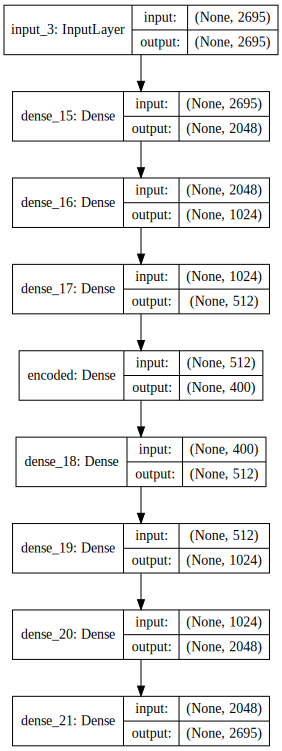

In [98]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
from keras.optimizers import Adadelta, Adam
from keras.objectives import MSE

In [175]:
ae.compile(optimizer=Adadelta(), loss=MSE)

In [176]:
history = ae.fit(X_train, X_train,
                    epochs=100,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 20836 samples, validate on 5210 samples
Epoch 1/100
20836/20836 [==============================] - 4s - loss: 0.3242 - val_loss: 0.2720
Epoch 2/100
20836/20836 [==============================] - 3s - loss: 0.2581 - val_loss: 0.2369
Epoch 3/100
20836/20836 [==============================] - 3s - loss: 0.2363 - val_loss: 0.2294
Epoch 4/100
20836/20836 [==============================] - 3s - loss: 0.2222 - val_loss: 0.2166
Epoch 5/100
20836/20836 [==============================] - 3s - loss: 0.2089 - val_loss: 0.2133
Epoch 6/100
20836/20836 [==============================] - 3s - loss: 0.1978 - val_loss: 0.1951
Epoch 7/100
20836/20836 [==============================] - 3s - loss: 0.1894 - val_loss: 0.1962
Epoch 8/100
20836/20836 [==============================] - 3s - loss: 0.1799 - val_loss: 0.1942
Epoch 9/100
20836/20836 [==============================] - 3s - loss: 0.1719 - val_loss: 0.1940
Epoch 10/100
20836/20836 [==============================] - 3s - loss: 0.1646 - val_los

In [177]:
X_pred = ae.predict(X_test)
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

Test MSE: 0.123591767005


In [178]:
ae_centrallayer.append(500)
loss.append(0.123591767005)

In [179]:
ae_centrallayer

[32, 64, 128, 200, 256, 300, 350, 400, 450, 500]

In [180]:
loss

[0.132214963844,
 0.132164419319,
 0.126055237301,
 0.126445099341,
 0.124675937853,
 0.124818255185,
 0.126347109927,
 0.124523848041,
 0.123448264761,
 0.123591767005]

In [172]:
ae.save('/home/mkarpov/CMS_Project/my_model_0.12344_450.h5')

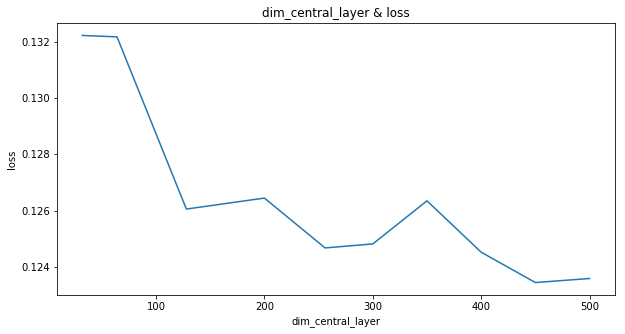

In [181]:
plt.figure(figsize=(10,5))
plt.plot(ae_centrallayer, loss)
plt.title('dim_central_layer & loss')
plt.ylabel('loss')
plt.xlabel('dim_central_layer')

## Modification of ae

In [119]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=0.07)
    regularization_coef = 1.0e-8
    
    
    inputs = Input(shape=(2695,))
    
    #Encoder
    dense1 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(inputs)
    
    dense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dense1)
      
        
    #Central layer
    encoded = Dense(
        700, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name='encoded'
    )(dense2)
    
    
    #Decoder
    dedense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(encoded)
    
    dedense2 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef))(dedense1)
    
    
    outputs = Dense(2695)(dedense2)
    
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [120]:
ae, ae_encoder = make_autoencoder()

In [121]:
ae.compile(optimizer=Adadelta(), loss=MSE)

In [ ]:
history = ae.fit(X_train, X_train,
                    epochs=100,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 20836 samples, validate on 5210 samples
Epoch 1/100


In [114]:
X_pred = ae.predict(X_test)
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

Test MSE: 0.11837265079


In [100]:
ae_centrallayer_new.append(1000)
loss_new.append(0.116381463995)

In [101]:
ae_centrallayer_new

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [102]:
loss_new

[0.124633839074,
 0.122950568671,
 0.117055882612,
 0.128094130186,
 0.116697390371,
 0.116167621179,
 0.115604940617,
 0.11895593368,
 0.118337590839,
 0.116381463995]

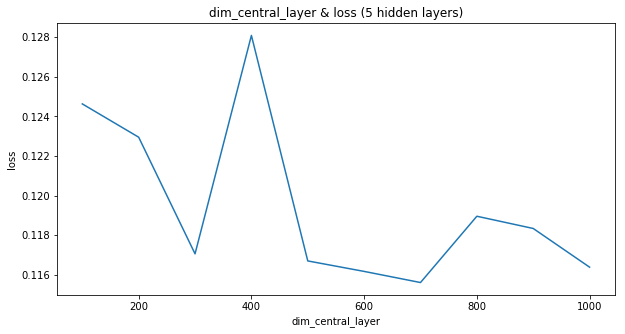

In [104]:
plt.figure(figsize=(10,5))
plt.plot(ae_centrallayer_new, loss_new)
plt.title('dim_central_layer & loss (5 hidden layers)')
plt.ylabel('loss')
plt.xlabel('dim_central_layer')
plt.savefig('dim_centrallayer&loss.png')

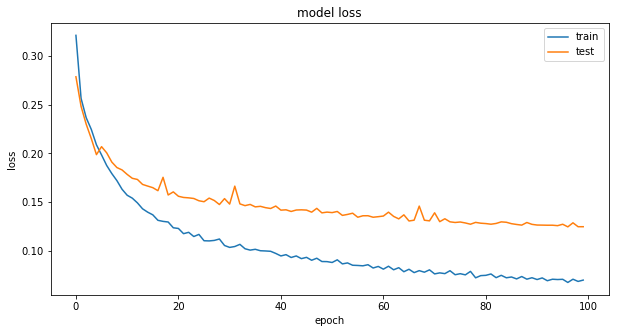

In [22]:
plt.figure(figsize=(10,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [23]:
X_all_MSE = []
for i in range(2695):
    X_prediction = np.mean((X_pred[:,i] - X_test[:,i]) ** 2)
    X_all_MSE.append(X_prediction)

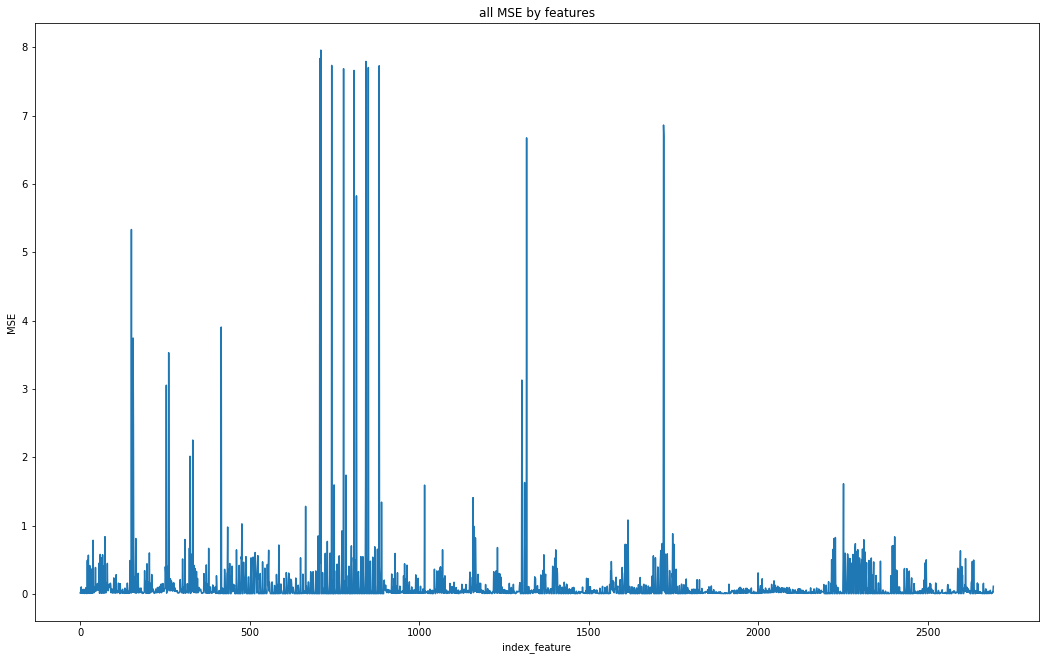

In [24]:
plt.figure(figsize=(18,11))
plt.plot(X_all_MSE)
plt.title('all MSE by features')
plt.ylabel('MSE')
plt.xlabel('index_feature')

In [25]:
X_all_MSE2 = []
idx = []
for i in range(len(X_pred[1])):
    X_prediction = np.mean((X_pred[:,i] - X_test[:,i]) ** 2)
    if X_prediction >= 2:
        idx.append(i)
        X_all_MSE2.append(X_prediction)

In [26]:
print('Number of features that have MSE >= 2', len(X_all_MSE2))
print(idx)

Number of features that have MSE >= 2 21
[151, 156, 157, 254, 261, 324, 332, 416, 707, 710, 742, 777, 808, 815, 843, 850, 882, 1303, 1317, 1721, 1722]


In [31]:
data_shuffle.iloc[:,idx]

,minibias_calo_eta__q1_p75,minibias_calo_eta__q2_p25,minibias_calo_eta__q2_p50,minibias_calo_fZ_q1_p25,minibias_calo_fZ_q2_p25,minibias_calo_phi__q1_p25,minibias_calo_phi__q2_p50,minibias_muons_Pz_p50,minibias_photons_eta__q3_p99,minibias_photons_eta__q4_p1,...,minibias_photons_fY_q3_p99,minibias_photons_fZ_q3_p1,minibias_photons_fZ_q4_p1,minibias_photons_phi__q3_p1,minibias_photons_phi__q4_p1,minibias_photons_pt__q3_p99,muons_muons_Px_std,muons_muons_Pz_std,muons_photons_fZ_q5_p25,muons_photons_fZ_q5_p50
11588,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.030550,0.013461,0.010634,0.006496
30389,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.020579,0.018268,0.010634,0.006496
2620,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.032953,0.027771,0.010634,0.006496
27313,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.037231,0.028844,0.010634,0.006496
10292,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.032283,0.027066,0.010634,0.006496
28322,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.031191,0.024628,0.010634,0.006496
219,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.032178,0.025055,0.010634,0.006496
30916,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.006832,0.010743,0.010634,0.006496
13811,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.035903,0.026870,0.010634,0.006496
12266,0.016197,0.010094,0.000651,0.006965,0.055,0.006782,0.002305,0.000986,0.004951,0.004951,...,0.004951,0.004951,0.007183,0.004951,0.004951,0.004951,0.034595,0.026431,0.010634,0.006496


In [38]:
calo = np.array(data_shuffle['minibias_photons_fX_q3_p99'])

j = []
for i in calo:
    if i != 0.0049507983868039961:
        j.append(i)
print (j)
print (len(j))

[201.98762338321626]
1


In [35]:
data['minibias_photons_eta__q4_p1'][0]

0.0049507983868039961

In [ ]:
minibias_PF_phi__q1_p50 170
minibias_calo_eta__q1_p75 6
minibias_calo_eta__q2_p25 36
minibias_calo_eta__q2_p50 4
minibias_calo_fZ_q1_p25 2
minibias_calo_fZ_q2_p25 279
minibias_calo_phi__q2_p50 4
minibias_muons_Px_p50 5
minibias_muons_Pz_p50 4
minibias_photons_eta__q3_p99 1 = 201.9876
minibias_photons_eta__q4_p1 1 = -201.9876
minibias_photons_fX_q3_p99 1 = 201.9876
minibias_photons_fY_q3_p99 1 = 201.9876
minibias_photons_fZ_q2_mean 36
minibias_photons_fZ_q3_p1 1 = -201.9876
minibias_photons_fZ_q4_p1 1 = -172.4399
minibias_photons_phi__q2_mean 36
minibias_photons_phi__q3_p1 1 = -201.9876
minibias_photons_phi__q4_p1 1 = -201.9876
minibias_photons_pt__q3_p99 1 = 201.9876
muons_photons_fZ_q5_p25 9
muons_photons_fZ_q5_p50 1 = -187.0160

In [27]:
history2 = ae.fit(X_train, X_train,
                    epochs=100,
                    batch_size=400,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 20836 samples, validate on 5210 samples
Epoch 1/100
20836/20836 [==============================] - 50s - loss: 0.1008 - val_loss: 0.1642

In [28]:
X_pred = ae.predict(X_test)
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.14853265651695327)


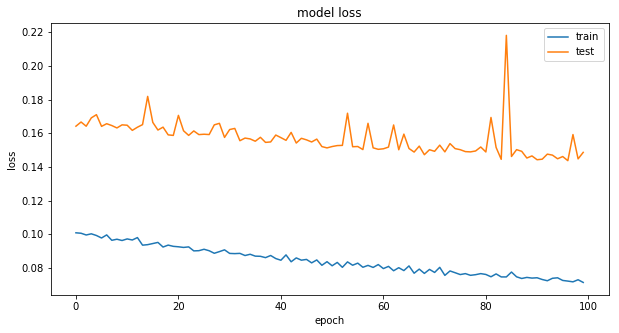

In [29]:
plt.figure(figsize=(10,5))
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [30]:
X_all_MSE = []
for i in range(2695):
    X_prediction = np.mean((X_pred[:,i] - X_test[:,i]) ** 2)
    X_all_MSE.append(X_prediction)

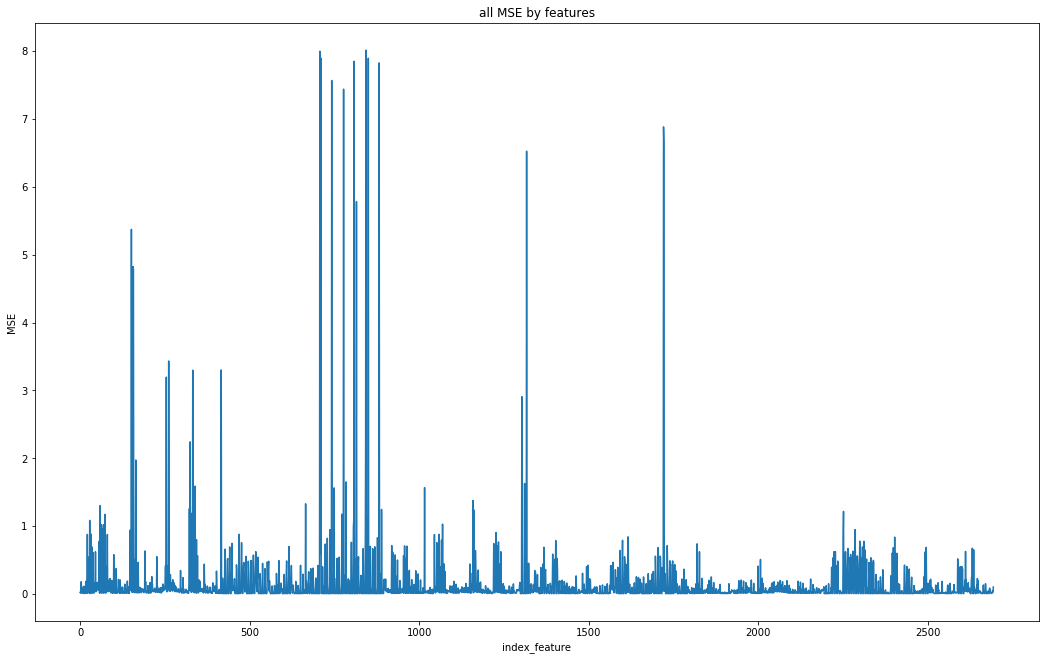

In [31]:
plt.figure(figsize=(18,11))
plt.plot(X_all_MSE)
plt.title('all MSE by features')
plt.ylabel('MSE')
plt.xlabel('index_feature')

In [32]:
X_all_MSE2 = []
idx = []
for i in range(len(X_pred[1])):
    X_prediction = np.mean((X_pred[:,i] - X_test[:,i]) ** 2)
    if X_prediction >= 2:
        idx.append(i)
        X_all_MSE2.append(X_prediction)

In [33]:
print('Number of features that have MSE >= 2', len(X_all_MSE2))
print(idx)

('Number of features that have MSE >= 2', 22)
[151, 156, 157, 254, 261, 324, 332, 416, 707, 710, 742, 777, 808, 815, 842, 843, 850, 882, 1303, 1317, 1721, 1722]
